<a href="https://colab.research.google.com/github/zekaouinoureddine/Advanced-transformer-based-models-on-opinion-mining/blob/master/notebooks/Movie_Reviews_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Movie Reviews GPT-2</strong></h1>

---

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 4.2 MB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 596 kB 57.3 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 


### Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!gdown --id 1xJYm-tNMllxx82_CQ1K1R5q0JW9KUV1j -q
!unzip IMDb.zip

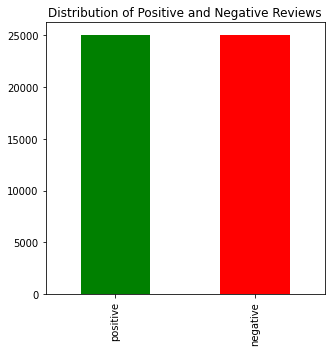

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

df["sentiment"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

### Config

In [ ]:
class Config:
  MAX_LEN = 384
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  GPT2_PATH = "gpt2"
  MODEL_PATH = "gpt2Model.bin"
  TRAINING_DATA = "IMDB Dataset.csv"

  TOKENIZER = transformers.GPT2Tokenizer.from_pretrained(GPT2_PATH, do_lower_case = True)
  TOKENIZER.add_special_tokens({'pad_token': '[PAD]'}) # Fix padding token issue

  MODEL = transformers.GPT2Model.from_pretrained(GPT2_PATH, return_dict=False)
  MODEL.resize_token_embeddings(len(TOKENIZER)) # Fix index out of range in self error

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

### Dataset

In [ ]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review
    
  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]


class MovieReviewDataset:
  def __init__(self,  review, label):
    self.review = review
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.review)
  
  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())
    
    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Model

In [ ]:
class GPT2Model(nn.Module):
  def __init__(self):
    super(GPT2Model, self).__init__()
    self.gpt2 = Config.MODEL
    self.gpt2_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
    hidden_states = outputs[0]
    go = self.gpt2_drop(hidden_states[:, 0])
    output = self.out(go)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
dfx.sentiment = dfx.sentiment.apply(lambda x: 1 if x == "positive" else 0)

df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.1, random_state=42, stratify=dfx.sentiment.values
    )

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = MovieReviewDataset(
    review=df_train.review.values, label=df_train.sentiment.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = MovieReviewDataset(
    review=df_valid.review.values, label=df_valid.sentiment.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = GPT2Model()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

100%|██████████| 1250/1250 [00:46<00:00, 26.90it/s]


Epoch: 1
Train Loss: 0.6995886139763726 - Train Accuracy: 0.5140222222222223 
Valid Loss: 0.6927982751607895 - Valid Accuracy: 0.5246



100%|██████████| 1250/1250 [00:46<00:00, 26.87it/s]


Epoch: 2
Train Loss: 0.6868792485343085 - Train Accuracy: 0.5391555555555556 
Valid Loss: 0.686365610408783 - Valid Accuracy: 0.5332



100%|██████████| 1250/1250 [00:46<00:00, 26.87it/s]


Epoch: 3
Train Loss: 0.681480619790819 - Train Accuracy: 0.5493777777777777 
Valid Loss: 0.6850508485794068 - Valid Accuracy: 0.5318



100%|██████████| 1250/1250 [00:46<00:00, 26.94it/s]


Epoch: 4
Train Loss: 0.6767778454939525 - Train Accuracy: 0.558 
Valid Loss: 0.6826585744142533 - Valid Accuracy: 0.545



### Error analysis & Performance Auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.545
Recall Score    : 0.5112
Precision Score : 0.5482625482625483
F1 Score        : 0.5290830055889051

Classification report 

               precision    recall  f1-score   support

         0.0       0.54      0.58      0.56      2500
         1.0       0.55      0.51      0.53      2500

    accuracy                           0.55      5000
   macro avg       0.55      0.54      0.54      5000
weighted avg       0.55      0.55      0.54      5000



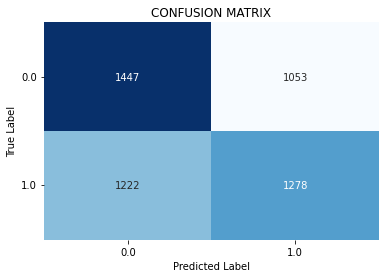

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

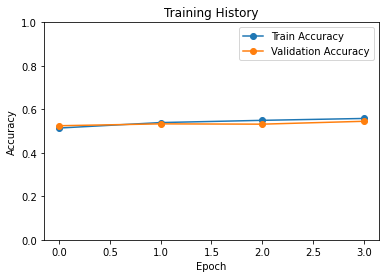

In [ ]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

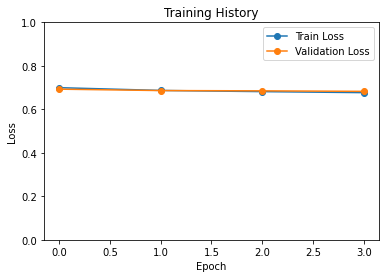

In [ ]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = GPT2Model()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask) 
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction
  
  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [ ]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.49161443', 'negative': '0.508385568857193'}


### References:
* **Alec Radford, Jeffrey Wu, Rewon Child, David Luan, Dario Amodei,
Ilya Sutskever . 2019. [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf).**